In [57]:
import numpy as np
import PIL
import random
from tqdm.notebook import tqdm
from IPython.core.display import Image, display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data

import math

import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(2)
np.random.seed(2)

# правильно выбирайте карту, иначе все упадет!
CUDA_DEVICE=3

def data2image(data):
    res = np.transpose(np.reshape(data, (3, 32, 32)), (1, 2, 0))
    return PIL.Image.fromarray(np.uint8(res))

def imshow(img):
    npimg = img.numpy().astype('uint8')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [58]:
!nvidia-smi

Mon Apr  4 16:03:00 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.43       Driver Version: 418.43       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   29C    P8     9W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   26C    P8     8W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [59]:
class CustomC100Dataset(data.Dataset):

    def __init__(self, dataset, dataset_type, img_cnt = 50000, transform = None, target_transform = None):

        if dataset_type not in ['train', 'test']:
            raise "Unknown dataset type : {}".format(dataset_type)

        self.dataset = dataset
        self.ds_type = dataset_type
        self.img_cnt = img_cnt
        self.transform = transform
        self.t_transform = target_transform
        self.__load__()
    
    def __load__(self):

        if self.ds_type == 'train':
            dataset = self.dataset
            dataset = dataset.reshape((self.img_cnt, 3073))
            self.y, self.x = np.hsplit(dataset, [1])
            self.y = self.y.astype(np.int64)
            self.x = self.x.reshape((self.x.shape[0], 3, 32, 32))
            self.x = self.x.transpose((0, 2, 3, 1))
        
        if self.ds_type == 'test':
            dataset = self.dataset.reshape((self.img_cnt, 3072))
            self.y = np.zeros((dataset.shape[0], 1), dtype=np.int64)
            self.x = dataset.reshape((dataset.shape[0], 3, 32, 32))
            self.x = self.x.transpose((0, 2, 3, 1))
    
    def __getitem__(self, index):

        img, target = self.x[index], self.y[index]
        
        img = PIL.Image.fromarray(img)
        
        if self.transform is not None:
            img = self.transform(img)

        if self.t_transform is not None:
            target = self.t_transform(target)
            
        return img, target

    
    def __len__(self):
        return len(self.x)

In [67]:
transform_train = transforms.Compose(
    [
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.8),
    transforms.RandomVerticalFlip(p=0.1),
    transforms.RandomRotation(5),
    transforms.RandomAffine(5),
   # transforms.Pad(4)
    transforms.ColorJitter(brightness=0.5, contrast=0.8, saturation=0.3, hue=0.01),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
    ]
)

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0, 0, 0], [1, 1, 1])
])

# подумайте, должны ли преобразования train и test сет быть абсолютно одинаковыми ?

dataset_train = np.load('homework_2.train.npy')

valid = np.load('homework_2_no_classes.test.npy')

np.random.seed(42)  

idx = list(range(50000))

sh = np.random.shuffle(idx)

train, test = dataset_train[idx[:45000]], dataset_train[idx[45000:]]

train_dataset = CustomC100Dataset(train, 'train',
                                  img_cnt = 45000, 
                                  transform = transform_train)

test_dataset = CustomC100Dataset(test, 'train',
                                  img_cnt = 5000, 
                                  transform = transform_test)

validation_dataset = CustomC100Dataset(valid, 'test',
                                    img_cnt = 10000,
                                    transform = transform_test)



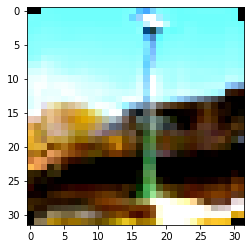

In [68]:
img, lbl = train_dataset[5]
imshow(img * 255)

In [69]:
class BasicBlock(nn.Module):
    
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()

        self.conv2d_1 = torch.nn.Conv2d(inplanes,
                                        planes,
                                        kernel_size=(3, 3),
                                        stride=stride, 
                                        padding=1,
                                        bias=False)
        
        self.bn_1 = torch.nn.BatchNorm2d(planes)
        self.activation = torch.nn.ReLU()
        self.conv2d_2 = torch.nn.Conv2d(planes,
                                  planes,
                                  kernel_size=(3, 3), 
                                  stride=stride, 
                                  padding=1,
                                  bias=False)
        
        self.bn_2 = torch.nn.BatchNorm2d(planes)
        
    def forward(self, x):
        x = self.conv2d_1(x)
        x = self.bn_1(x)
        x = self.activation(x)
        
        x = self.conv2d_2(x)
        x = self.bn_2(x)

        return self.activation(x)

In [70]:
class BottleNeck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super().__init__()
        
        self.conv2d_1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn_1 = nn.BatchNorm2d(planes)
        
        self.activation = torch.nn.ReLU(inplace=True)
        
        self.conv2d_2 = nn.Conv2d(planes, planes, stride=stride, kernel_size=3, padding=1, bias=False)
        self.bn_2 = nn.BatchNorm2d(planes)
        
        self.conv2d_3 = nn.Conv2d(planes, planes * BottleNeck.expansion, kernel_size=1, bias=False)
        self.bn_3 = nn.BatchNorm2d(planes * BottleNeck.expansion)
        
        self.downsample = nn.Sequential()
        
        if stride != 1 or inplanes != planes * BottleNeck.expansion:
            self.downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes * BottleNeck.expansion, stride=stride, kernel_size=1, bias=False),
                nn.BatchNorm2d(planes * BottleNeck.expansion)
            )


    def forward(self, x):
        
        y = self.downsample(x)
        
        x = self.conv2d_1(x)
        x = self.bn_1(x)
        x = self.activation(x)
        
        x = self.conv2d_2(x)
        x = self.bn_2(x)
        x = self.activation(x)
        
        x = self.conv2d_3(x)
        x = self.bn_3(x)
        
        return self.activation(x + y)

In [71]:
# чтобы вы не запутались, сборку самой модели предоставляем
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes=100):
        
        super(ResNet, self).__init__()
        self.inplanes = 16
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=(3, 3), stride=1, padding=1, bias=False)
        self.bn1 = torch.nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 32, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 64, layers[2], stride=2)
        self.avgpool = nn.AvgPool2d(8)

        self.fc = nn.Linear(64 * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
#         if stride != 1 or self.inplanes != planes * block.expansion:
#             downsample = nn.Sequential(
#                 nn.Conv2d(self.inplanes, block.expansion * planes, kernel_size=1, stride=stride, bias=False),
#                 nn.BatchNorm2d(block.expansion * planes)
#             )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        # print("[conv1]", x.shape)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        # print("[layer1]", x.shape)
        x = self.layer2(x)
        # print("[layer2]", x.shape)
        x = self.layer3(x)
        # print("[layer3]", x.shape)

        x = self.avgpool(x)
        # print("[avgpool]", x.shape)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [72]:
# Выбирайте любой ResNet

def ResNet20():
    return ResNet(BottleNeck, [3, 3, 3], 100)

def ResNet32():
    return ResNet(BottleNeck, [5, 5, 5], 100)

def ResNet44():
    return ResNet(BottleNeck, [7, 7, 7], 100)

def ResNet56():
    return ResNet(BottleNeck, [9, 9, 9], 100)

In [73]:
def acc_check(model, validation_loader, batch_size):
    model.eval()
    correct = 0.0
    total = 0.0
    
    for batch_idx, (inputs, labels) in enumerate(validation_loader):
        inputs, labels = inputs.cuda(CUDA_DEVICE), labels.view(batch_size).cuda(CUDA_DEVICE)
        outputs = model(inputs)
        outputs = F.softmax(outputs)
        prob, predicted = torch.topk(outputs.data, 1)
        total += labels.size(0)
        correct += predicted.view(-1).eq(labels.data).sum()
        
    model.train()
    return (correct / total)

In [74]:
def make_solution_pytorch(model, test_data_loader, batch_size):
    res = []
    model.eval()
    for batch_idx, (inputs, labels) in enumerate(test_data_loader):
        inputs, labels = inputs.cuda(CUDA_DEVICE), labels.view(batch_size).cuda(CUDA_DEVICE)
        outputs = model(inputs)
        outputs = F.softmax(outputs)
        prob, predicted = torch.topk(outputs.data, 1)
        res = np.append(res, predicted.view(-1).cpu().numpy())
    model.train()
    return res

In [75]:
def write2file(path, data, i):
    types: str = 'w' if not i else 'a'
    with open(path, types) as f:
        f.write(str(data.cpu().numpy()) + '\n')

In [76]:
model = ResNet56().cuda(CUDA_DEVICE)

In [77]:
!nvidia-smi

Mon Apr  4 16:04:13 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.43       Driver Version: 418.43       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 108...  Off  | 00000000:02:00.0 Off |                  N/A |
| 23%   29C    P8     9W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  Off  | 00000000:03:00.0 Off |                  N/A |
| 23%   26C    P8     8W / 250W |     10MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [ ]:
#Обучение ResNet
#Не забудьте вывести графики accuracy (можно использовать acc_check()) и loss при обучении

#all parameters from https://arxiv.org/pdf/1512.03385.pdf
epochs_cnt = 110 # кол-во эпох

# эти параметры тоже на ваше усмотрение
minibatch_size = 200
test_batch_size = 100

#optimizer = optim.Adam(model.parameters(), lr=1e-3, betas=(0.8, 0.999))
optimizer = optim.SGD(model.parameters(), momentum=0.9, lr=1e-1, nesterov=True)

criterion = nn.CrossEntropyLoss().cuda(CUDA_DEVICE)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30, 50, 70, 80, 90], gamma=0.2, verbose=True)


test_loader = torch.utils.data.DataLoader(test_dataset, batch_size = test_batch_size, shuffle = False, num_workers = 2)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size = test_batch_size, shuffle = False, num_workers = 2)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = minibatch_size, shuffle = True, num_workers = 2)
losses = []
acc = []

# примерный код для обучения модели, не обязательно строго следовать ему
for epoch in tqdm(range(epochs_cnt)):    
    train_loss = 0
    
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        
        if batch_idx % 10 == 0 and batch_idx:
            losses.append(train_loss / 10)
            train_loss = 0
        
        inputs, labels = inputs.cuda(CUDA_DEVICE), labels.view(minibatch_size).cuda(CUDA_DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels).cuda(CUDA_DEVICE)
        losses.append(loss.data)
        train_loss += loss.data
        loss.backward()
        optimizer.step()

    acc.append(acc_check(model, test_loader, test_batch_size))
    print(f'################################### \n {epoch + 1} / {epochs_cnt} \n acc - {acc[-1]}')
    
    scheduler.step()
    
    if epoch > 10 and acc[-1] > max(acc[:-1]):
        torch.save(model.state_dict(), "model.pth")
        
        solution = make_solution_pytorch(model, validation_loader, test_batch_size)
        with open('result.csv', 'w') as fout:
            print('Id', 'Prediction', sep=',', file=fout)
            for i, prediction in enumerate(solution):
                print(i, int(prediction), sep=',', file=fout)
    
    if acc[-1] > 0.68:
        break

print('Finished Training')

Adjusting learning rate of group 0 to 1.0000e-01.


/home/d.devyatkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


################################### 
 1 / 110 
 acc - 0.019999999552965164
Adjusting learning rate of group 0 to 1.0000e-01.
################################### 
 2 / 110 
 acc - 0.02539999969303608
Adjusting learning rate of group 0 to 1.0000e-01.
################################### 
 3 / 110 
 acc - 0.05199999734759331
Adjusting learning rate of group 0 to 1.0000e-01.
################################### 
 4 / 110 
 acc - 0.0722000002861023
Adjusting learning rate of group 0 to 1.0000e-01.
################################### 
 5 / 110 
 acc - 0.1005999967455864
Adjusting learning rate of group 0 to 1.0000e-01.
################################### 
 6 / 110 
 acc - 0.121799997985363
Adjusting learning rate of group 0 to 1.0000e-01.
################################### 
 7 / 110 
 acc - 0.1501999944448471
Adjusting learning rate of group 0 to 1.0000e-01.
################################### 
 8 / 110 
 acc - 0.18239998817443848
Adjusting learning rate of group 0 to 1.0000e-01.
############

/home/d.devyatkin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


################################### 
 13 / 110 
 acc - 0.36820000410079956
Adjusting learning rate of group 0 to 1.0000e-01.
################################### 
 14 / 110 
 acc - 0.3813999891281128
Adjusting learning rate of group 0 to 1.0000e-01.
################################### 
 15 / 110 
 acc - 0.39559999108314514
Adjusting learning rate of group 0 to 1.0000e-01.
################################### 
 16 / 110 
 acc - 0.42980000376701355
Adjusting learning rate of group 0 to 1.0000e-01.
################################### 
 17 / 110 
 acc - 0.44279998540878296
Adjusting learning rate of group 0 to 1.0000e-01.
################################### 
 18 / 110 
 acc - 0.4490000009536743
Adjusting learning rate of group 0 to 1.0000e-01.
################################### 
 19 / 110 
 acc - 0.47039997577667236
Adjusting learning rate of group 0 to 1.0000e-01.
################################### 
 20 / 110 
 acc - 0.48339998722076416
Adjusting learning rate of group 0 to 1.0000e-01.
##

################################### 
 80 / 110 
 acc - 0.6010000109672546
Adjusting learning rate of group 0 to 1.6000e-04.


In [ ]:
fig, axs = plt.subplots(2, figsize=(16, 8))
fig.suptitle(f"max accuracy is {max([i.cpu().numpy() for i in acc])}")
axs[0].semilogy([i.cpu().numpy() for i in losses])
axs[1].plot([i.cpu().numpy() for i in acc])